In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.set_random_seed(10)
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 16, # was 10
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [2]:
# Generating training data that goes from initial condition location to PCA coefficient trajectory
num_modes=40
locs = np.load('../../SWE_Data/Data/Locations.npy')
pca_coeffs = np.load('../../SWE_Data/PCA_Coefficients_q1.npy')[0:num_modes,:]

coeff_scaler = MinMaxScaler()
pca_coeffs_scaled = np.transpose(coeff_scaler.fit_transform(np.transpose(pca_coeffs)))

In [3]:
num_sims = np.shape(locs)[0]
num_ivs = np.shape(locs)[1]
num_coeffs = np.shape(pca_coeffs)[0]
burn_in = 20

In [4]:
# Reshape
training_data_ip = np.zeros(shape=(num_sims,num_coeffs+num_ivs,burn_in),dtype='double')
training_data_op = np.zeros(shape=(num_sims,num_coeffs+num_ivs,500-burn_in),dtype='double')

for sim in range(num_sims):
    training_data_ip[sim,:-num_ivs,:] = pca_coeffs_scaled[:,500*sim:500*sim+burn_in]
    training_data_ip[sim,-num_ivs:,:] = locs[sim,:,None]
    training_data_op[sim,:-num_ivs,:] = pca_coeffs_scaled[:,500*sim+burn_in:500*(sim+1)]
    training_data_op[sim,-num_ivs:,:] = locs[sim,:,None]

In [5]:
from tensorflow.keras.layers import Input, Dense, Lambda, Add, LSTM, Dropout, Bidirectional
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

In [6]:
weights_filepath = 'NA_BLSTM_P.h5'

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [7]:
# Best hyperparameters found using Deephyper - first line of results.csv

lstm_inputs = Input(shape=(num_coeffs+num_ivs,burn_in),name='nat_inputs')
h1 = Bidirectional(LSTM(145,return_sequences=True))(lstm_inputs)
h2 = Bidirectional(LSTM(145,return_sequences=True))(h1)
lstm_outputs = Dense(500-burn_in,activation=None)(h2)

lstm_model = Model(inputs=lstm_inputs,outputs=lstm_outputs)
 
# design network
my_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,EarlyStoppingByLossVal()]

# fit network
lstm_model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
lstm_model.summary()

W0204 10:49:52.075836 140134643443520 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0204 10:49:52.082717 140134643443520 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0204 10:49:52.083841 140134643443520 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/pyth

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nat_inputs (InputLayer)      [(None, 42, 20)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 42, 290)           192560    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 42, 290)           505760    
_________________________________________________________________
dense (Dense)                (None, 42, 480)           139680    
Total params: 838,000
Trainable params: 838,000
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 5000
batch_size = 4
train_mode = False ## Careful

from time import time
if train_mode:
    start_time = time()
    train_history = lstm_model.fit(x=training_data_ip, y=training_data_op, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)
    end_time = time()
    np.save('NA_BLSTM_P.npy',train_history.history['loss'])

In [9]:
import matplotlib.pyplot as plt
lstm_model.load_weights(weights_filepath)

# Testing
filename = '../../SWE_Data/Data/snapshot_matrix_pod_test.npy'
test_data = np.load(filename)[0:64*64,:]
pca_vectors = np.load('../../SWE_Data/PCA_Vectors_q1.npy')[:64*64,:num_modes]

true_pca_evol = coeff_scaler.transform(np.matmul(np.transpose(test_data),pca_vectors))
test_data = np.zeros(shape=(1,num_coeffs+num_ivs,500))
test_data[0,0:num_coeffs,:] = np.transpose(true_pca_evol[:,:])

test_data[0,-2,:] = -1.0/2.7
test_data[0,-1,:] = -1.0/4.0

In [10]:
pred_pca = lstm_model.predict(test_data[:,:,:burn_in])
pred_pca = np.concatenate((test_data[:,:,:burn_in],pred_pca),axis=-1)

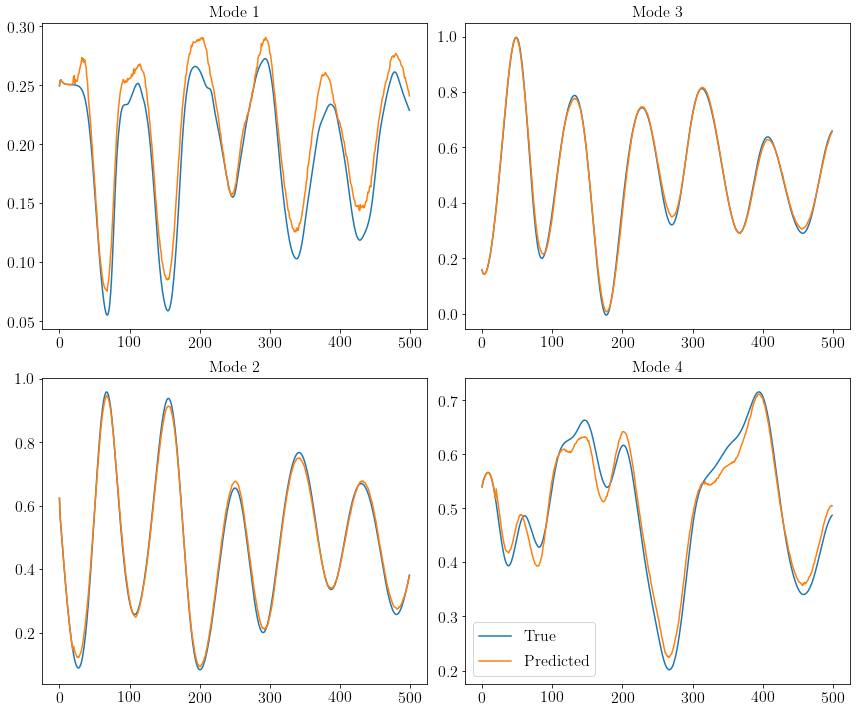

In [11]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
ax[0,0].plot(test_data[0,0,:],label='True')
ax[0,0].plot(pred_pca[0,0,:],label='Predicted')
ax[0,0].set_title('Mode 1')


ax[1,0].plot(test_data[0,1,:],label='True')
ax[1,0].plot(pred_pca[0,1,:],label='Predicted')
ax[1,0].set_title('Mode 2')

ax[0,1].plot(test_data[0,2,:],label='True')
ax[0,1].plot(pred_pca[0,2,:],label='Predicted')
ax[0,1].set_title('Mode 3')

ax[1,1].plot(test_data[0,3,:],label='True')
ax[1,1].plot(pred_pca[0,3,:],label='Predicted')
ax[1,1].set_title('Mode 4')

plt.tight_layout()
plt.legend()
plt.show()

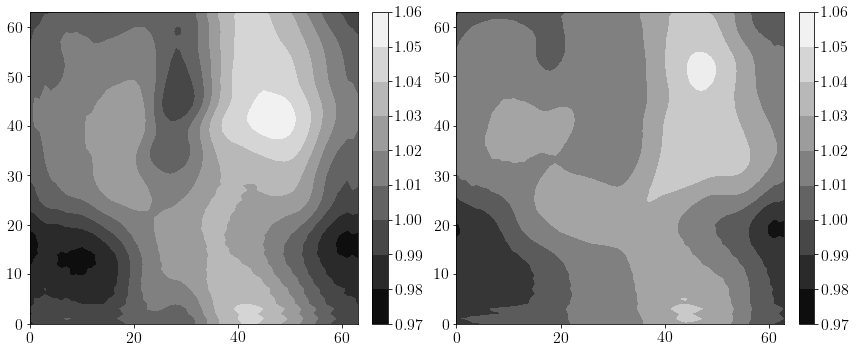

In [12]:
# Plotting some contours
# True field
true_rb = np.transpose(coeff_scaler.inverse_transform(true_pca_evol))
true_recon = np.matmul(pca_vectors,true_rb)[:,-2].reshape(64,64)

pred_rb = np.transpose(pred_pca[0,:num_modes,:])
pred_rb = np.transpose(coeff_scaler.inverse_transform(pred_rb))
pred_recon = np.matmul(pca_vectors,pred_rb)[:,-2].reshape(64,64)


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
cx = ax[0].contourf(true_recon)
ax[1].contourf(pred_recon)

fig.colorbar(cx,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cx,ax=ax[1],fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [13]:
if train_mode:
    np.save('../Figures/NA_BLSTM_P_Preds.npy',pred_pca)
    np.save('../Figures/NA_BLSTM_P_Fields.npy',pred_recon)